In [1]:
%pylab notebook
from time import sleep
import sys
rcParams["axes.grid"] = True

sys.path.append("..")
from common import *

sys.path.append("../linux/csr_access/py/")
from csr_lib import CsrLib, CsrLibLegacyAdapter
from vvm_helpers import initLTC, getSamples, getNyquist, meas_f_ref, twos_comps, getMags, getPhases, MagCal

from socket_instrument import SocketInstrument
from skrf import Network, Frequency

Populating the interactive namespace from numpy and matplotlib


# Connect and init VVM

In [5]:
r = conLitexServer('../../build/csr.csv')
c = CsrLibLegacyAdapter(r)
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
initLTC(c)

Connected to Port 1234
Zedboard RF vector volt-meter 2020-01-06 12:30:34
f_sample: 117.600758 MHz
Resetting LTC
autoBitslip(): aligned after 2
ID: 16  F: 11110000
CH0: 0000000000000001
CH1: 0000000000000001
CH2: 0000000000000001
CH3: 0000000000000001
autoIdelay(): min = 9, mean = 15, max = 21 idelays


# Setup VVM parameters

In [6]:
# Frequency / bandwidth setting
vvm_ddc_deci = 100  # vvm_ddc_decimation factor
vvm_ddc_shift = 2
f_sample = 117.6e6  # Sampling clock frequency
Ms = (1, 1, 1, 1) # Measurement harmonic
iir_shift = 2

# Setup vvm_ddc_decimation factor
r.regs.vvm_ddc_deci.write(vvm_ddc_deci)

# Throw away N bits after CIC to avoid saturation with large vvm_ddc_deci factors
# This will change the scaling!
r.regs.vvm_ddc_shift.write(vvm_ddc_shift)

# IIR result averaging filter smoothing factor (0 - 15)
r.regs.vvm_iir.write(iir_shift)
   
print('f_sample', r.regs.lvds_f_sample_value.read() / 1e6, "MHz")
print('f_ref', meas_f_ref(c, f_sample) / 1e6, "MHz")
print('vvm_ddc_deci', r.regs.vvm_ddc_deci.read())
print('bw', f_sample / vvm_ddc_deci / 1e6, "MHz")
print('iir_shift', r.regs.vvm_iir.read())

f_sample 117.600758 MHz
f_ref 1.77868824 MHz
vvm_ddc_deci 100
bw 1.176 MHz
iir_shift 2


In [15]:
def set_center_freq(f_ref):
    ftw = int(((f_ref / f_sample) % 1) * 2**32)
    # Setup center frequency / measurement harmonic
    for i, mult in enumerate(Ms):
        ftw_ = int(ftw * mult)
        getattr(r.regs, 'vvm_ddc_dds_ftw{}'.format(i)).write(ftw_)
        if i > 0:
            getattr(r.regs, 'vvm_pp_mult{}'.format(i)).write(mult)
    r.regs.vvm_ddc_dds_ctrl.write(0x2)  # FTW_UPDATE

def doSweep(f_test):
    mags = []
    phases = []
    for f in f_test:
        s.write("SOURCE:FREQUENCY {:}".format(f))
        set_center_freq(f)
        sleep(.1)
        mags.append(getMags(r, vvm_ddc_shift))
        phases.append(getPhases(r))
    mags = vstack(mags)
    phases = vstack(phases)
    return mags, phases

def getBadInds(f_test, f_sample, f_thr=1e6):
    ''' Indicate frequencies too close to 0 Hz or N * fSample / 2 '''
    bad_inds = zeros_like(f_test, dtype=bool)
    for i in range(16):
        bad_f = f_sample / 2 * i
        bad_inds |= abs(f_test - bad_f) < f_thr
    return bad_inds

In [7]:
set_center_freq(499.6e6)

In [12]:
getMags(r, vvm_ddc_shift)

array([ -8.23754202, -68.11405394, -88.59070613, -92.11253131])

In [15]:
getPhases(r)

array([98.62838745, 59.34548378,  5.94583511])

# Connect to RS SMA100A

In [10]:
s = SocketInstrument("128.3.131.26", 5025)
s.__enter__()

In [11]:
s.ask("*IDN?")

'Rohde&Schwarz,SMA100A,1400.0000k02/111390,3.1.19.15-3.50.057.29'

# Do a frequency sweep

In [18]:
f_test = linspace(10e6, 800e6, 500)
p_test = 10.0 # [dBm]

bad_inds = getBadInds(f_test, f_sample)
# f_test = f_test[~bad_inds]
mag_results = zeros((len(f_test), 4))

In [29]:
CH = 3
mags, phases = doSweep(f_test)
mag_results[:, CH] = mags[:, CH]

<IPython.core.display.Javascript object>


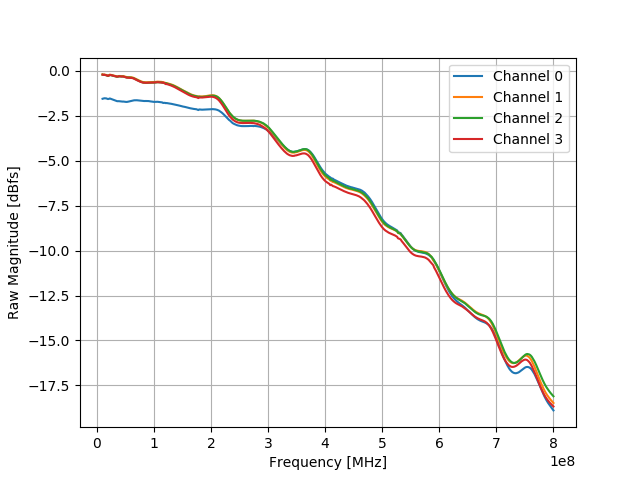

In [30]:
close()
fig, ax = subplots(1, 1)

# for f in f_test[bad_inds]:
#     ax.axvline(f, color="red", alpha=0.5)

for i in range(mag_results.shape[1]):
    ax.plot(f_test[~bad_inds], mag_results[~bad_inds, i], label="Channel {:}".format(i))
    
ax.set_xlabel("Frequency [MHz]")
ax.set_ylabel("Raw Magnitude [dBfs]")
ax.legend()

__Somethings wrong with Channel 0!!! :(__

# Measurement cable insertion loss

In [33]:
def getS21(s2p_file, f_test):
    cab = Network(s2p_file)
    cab.resample(Frequency.from_f(f_test, unit="Hz"))
#     print(cab)
#     close()
#     cab.plot_s_db(1,0)
    return 20 * log10(abs(cab.s[:, 1, 0]))
#     return abs(cab.s[:, 1, 0])

In [36]:
cab_s21mag_db = getS21('vna/CAB.S2P', f_test)

# Save cal file

In [39]:
savez(
    "cal1.npz", 
    f_test=f_test, 
    mag_results=mag_results, 
    bad_inds=bad_inds,
    vvm_ddc_deci=vvm_ddc_deci,
    vvm_ddc_shift=vvm_ddc_shift,
    f_sample=f_sample,
    Ms=Ms,
    iir_shift=iir_shift,
    cab_s21mag_db=cab_s21mag_db,
    p_test=p_test
)

# Load cal file

In [8]:
cal = MagCal('cal1.npz')

### do a quick sweep and confirm cal

In [28]:
def plot_cal(CH, f_test):
    bad_inds = getBadInds(f_test, f_sample)
    f_test = f_test[~bad_inds]

    mags, phases = doSweep(f_test)
    mags_cor = cal.correct_mags(mags, f_test)

    plot(f_test, mags[:, CH], label="Raw magnitude [dBfs]")
    plot(f_test, mags_cor[:, CH], label="Corrected [dBm]")
    xlabel("Frequency [MHz]")
    ylabel("Power")
    title("Channel {}".format(CH))
    legend()

<IPython.core.display.Javascript object>


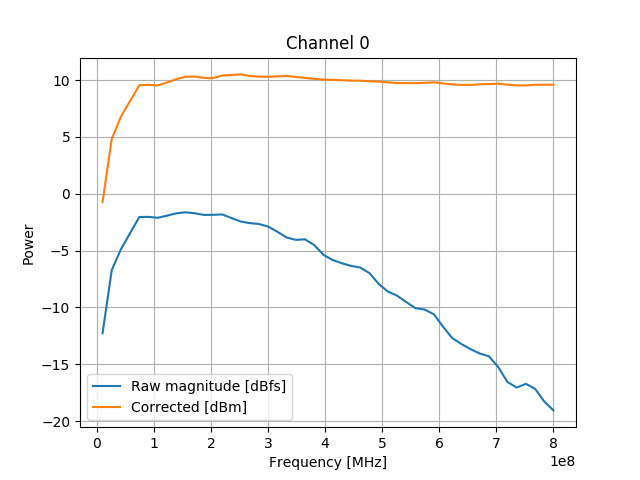

In [33]:
plot_cal(0, linspace(10e6, 800e6, 50))

# Something's up with channel 0!!!

<IPython.core.display.Javascript object>


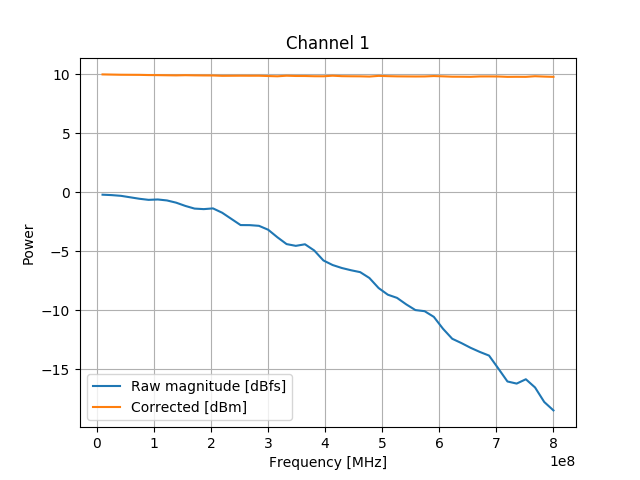

In [29]:
plot_cal(1, linspace(10e6, 800e6, 50))

<IPython.core.display.Javascript object>


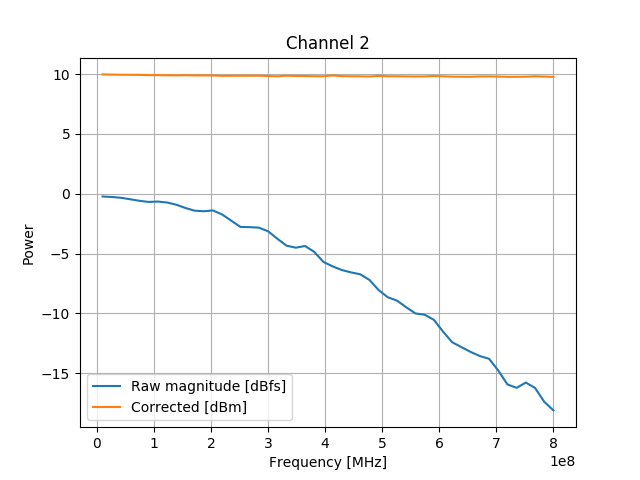

In [30]:
plot_cal(2, linspace(10e6, 800e6, 50))

<IPython.core.display.Javascript object>


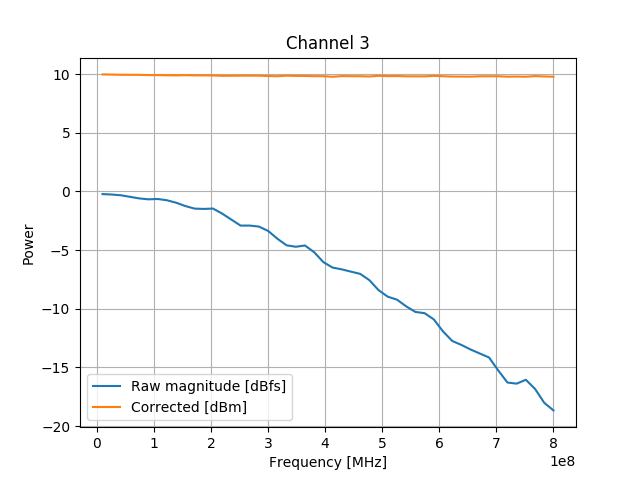

In [34]:
plot_cal(3, linspace(10e6, 800e6, 50))